# HAR CNN training 

In [1]:
# Imports
import numpy as np
import os
from utils.semg_utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
path = os.path.abspath(os.getcwd())
X_train, labels_train, list_ch_train = read_data(data_path= path + "\\sEMG\\Database 2\\male_day_1\\", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path= path + "\\sEMG\\Database 2\\male_day_2\\", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [3]:
# Normalize?
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [6]:
# Imports
import tensorflow as tf

### Hyperparameters

In [7]:
batch_size = 25       # Batch size
seq_len = 2500          # Number of steps
learning_rate = 0.0001
epochs = 1000

n_classes = 6
n_channels = 2

### Construct the graph
Placeholders

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

Note: Should we use a different activation? Like tf.nn.tanh?

In [9]:
with graph.as_default():
    # (batch, 2500, 2) --> (batch, 1250, 4)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=4, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 1250, 4) --> (batch, 625, 8)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=8, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    # conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=16, kernel_size=2, strides=1, 
    #                          padding='same', activation = tf.nn.relu)
    # max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    # conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=32, kernel_size=2, strides=1, 
    #                          padding='same', activation = tf.nn.relu)
    # max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Now, flatten and pass to the classifier

In [10]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_2, (-1, 8 * 625))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [11]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [12]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 2.281605 Train acc: 0.160000
Epoch: 0/1000 Iteration: 10 Train loss: 2.517508 Train acc: 0.120000
Epoch: 0/1000 Iteration: 10 Validation loss: 1.888062 Validation acc: 0.240000
Epoch: 0/1000 Iteration: 15 Train loss: 2.115704 Train acc: 0.200000
Epoch: 1/1000 Iteration: 20 Train loss: 1.950690 Train acc: 0.360000
Epoch: 1/1000 Iteration: 20 Validation loss: 1.808570 Validation acc: 0.206667
Epoch: 1/1000 Iteration: 25 Train loss: 2.078016 Train acc: 0.240000
Epoch: 1/1000 Iteration: 30 Train loss: 1.877275 Train acc: 0.160000
Epoch: 1/1000 Iteration: 30 Validation loss: 1.754001 Validation acc: 0.226667
Epoch: 1/1000 Iteration: 35 Train loss: 2.014634 Train acc: 0.120000
Epoch: 2/1000 Iteration: 40 Train loss: 2.032674 Train acc: 0.160000
Epoch: 2/1000 Iteration: 40 Validation loss: 1.693638 Validation acc: 0.273333
Epoch: 2/1000 Iteration: 45 Train loss: 1.730427 Train acc: 0.320000
Epoch: 2/1000 Iteration: 50 Train loss: 1.851646 Train acc: 0.20

Epoch: 21/1000 Iteration: 395 Train loss: 1.054844 Train acc: 0.680000
Epoch: 22/1000 Iteration: 400 Train loss: 1.054740 Train acc: 0.480000
Epoch: 22/1000 Iteration: 400 Validation loss: 1.139927 Validation acc: 0.506667
Epoch: 22/1000 Iteration: 405 Train loss: 0.813110 Train acc: 0.680000
Epoch: 22/1000 Iteration: 410 Train loss: 0.845362 Train acc: 0.640000
Epoch: 22/1000 Iteration: 410 Validation loss: 1.133775 Validation acc: 0.500000
Epoch: 23/1000 Iteration: 415 Train loss: 1.093018 Train acc: 0.520000
Epoch: 23/1000 Iteration: 420 Train loss: 0.696030 Train acc: 0.720000
Epoch: 23/1000 Iteration: 420 Validation loss: 1.130349 Validation acc: 0.486667
Epoch: 23/1000 Iteration: 425 Train loss: 1.008533 Train acc: 0.560000
Epoch: 23/1000 Iteration: 430 Train loss: 0.660946 Train acc: 0.800000
Epoch: 23/1000 Iteration: 430 Validation loss: 1.125589 Validation acc: 0.486667
Epoch: 24/1000 Iteration: 435 Train loss: 0.861986 Train acc: 0.840000
Epoch: 24/1000 Iteration: 440 Train l

Epoch: 42/1000 Iteration: 770 Train loss: 0.396040 Train acc: 0.960000
Epoch: 42/1000 Iteration: 770 Validation loss: 1.068268 Validation acc: 0.520000
Epoch: 43/1000 Iteration: 775 Train loss: 0.670051 Train acc: 0.760000
Epoch: 43/1000 Iteration: 780 Train loss: 0.705392 Train acc: 0.720000
Epoch: 43/1000 Iteration: 780 Validation loss: 1.070462 Validation acc: 0.500000
Epoch: 43/1000 Iteration: 785 Train loss: 0.642872 Train acc: 0.840000
Epoch: 43/1000 Iteration: 790 Train loss: 0.667469 Train acc: 0.760000
Epoch: 43/1000 Iteration: 790 Validation loss: 1.069302 Validation acc: 0.513333
Epoch: 44/1000 Iteration: 795 Train loss: 0.630294 Train acc: 0.760000
Epoch: 44/1000 Iteration: 800 Train loss: 0.760180 Train acc: 0.720000
Epoch: 44/1000 Iteration: 800 Validation loss: 1.072697 Validation acc: 0.493333
Epoch: 44/1000 Iteration: 805 Train loss: 0.629110 Train acc: 0.720000
Epoch: 44/1000 Iteration: 810 Train loss: 0.593457 Train acc: 0.880000
Epoch: 44/1000 Iteration: 810 Validat

Epoch: 64/1000 Iteration: 1155 Train loss: 0.411917 Train acc: 0.840000
Epoch: 64/1000 Iteration: 1160 Train loss: 0.551786 Train acc: 0.800000
Epoch: 64/1000 Iteration: 1160 Validation loss: 1.058390 Validation acc: 0.520000
Epoch: 64/1000 Iteration: 1165 Train loss: 0.441501 Train acc: 0.880000
Epoch: 64/1000 Iteration: 1170 Train loss: 0.564355 Train acc: 0.800000
Epoch: 64/1000 Iteration: 1170 Validation loss: 1.060703 Validation acc: 0.513333
Epoch: 65/1000 Iteration: 1175 Train loss: 0.530993 Train acc: 0.840000
Epoch: 65/1000 Iteration: 1180 Train loss: 0.599516 Train acc: 0.800000
Epoch: 65/1000 Iteration: 1180 Validation loss: 1.061295 Validation acc: 0.520000
Epoch: 65/1000 Iteration: 1185 Train loss: 0.487714 Train acc: 0.800000
Epoch: 66/1000 Iteration: 1190 Train loss: 0.390960 Train acc: 0.920000
Epoch: 66/1000 Iteration: 1190 Validation loss: 1.054950 Validation acc: 0.526667
Epoch: 66/1000 Iteration: 1195 Train loss: 0.316608 Train acc: 0.960000
Epoch: 66/1000 Iteration

Epoch: 86/1000 Iteration: 1560 Train loss: 0.359356 Train acc: 0.960000
Epoch: 86/1000 Iteration: 1560 Validation loss: 1.056715 Validation acc: 0.533333
Epoch: 86/1000 Iteration: 1565 Train loss: 0.347256 Train acc: 0.880000
Epoch: 87/1000 Iteration: 1570 Train loss: 0.517972 Train acc: 0.840000
Epoch: 87/1000 Iteration: 1570 Validation loss: 1.061864 Validation acc: 0.526667
Epoch: 87/1000 Iteration: 1575 Train loss: 0.358020 Train acc: 0.840000
Epoch: 87/1000 Iteration: 1580 Train loss: 0.271449 Train acc: 0.920000
Epoch: 87/1000 Iteration: 1580 Validation loss: 1.049990 Validation acc: 0.560000
Epoch: 88/1000 Iteration: 1585 Train loss: 0.324710 Train acc: 0.920000
Epoch: 88/1000 Iteration: 1590 Train loss: 0.294108 Train acc: 0.880000
Epoch: 88/1000 Iteration: 1590 Validation loss: 1.049811 Validation acc: 0.566667
Epoch: 88/1000 Iteration: 1595 Train loss: 0.345879 Train acc: 0.840000
Epoch: 88/1000 Iteration: 1600 Train loss: 0.302033 Train acc: 0.960000
Epoch: 88/1000 Iteration

Epoch: 109/1000 Iteration: 1965 Train loss: 0.218412 Train acc: 0.960000
Epoch: 109/1000 Iteration: 1970 Train loss: 0.252428 Train acc: 1.000000
Epoch: 109/1000 Iteration: 1970 Validation loss: 1.073300 Validation acc: 0.540000
Epoch: 109/1000 Iteration: 1975 Train loss: 0.175658 Train acc: 0.960000
Epoch: 109/1000 Iteration: 1980 Train loss: 0.168683 Train acc: 0.960000
Epoch: 109/1000 Iteration: 1980 Validation loss: 1.079744 Validation acc: 0.546667
Epoch: 110/1000 Iteration: 1985 Train loss: 0.258603 Train acc: 0.960000
Epoch: 110/1000 Iteration: 1990 Train loss: 0.317158 Train acc: 0.920000
Epoch: 110/1000 Iteration: 1990 Validation loss: 1.074310 Validation acc: 0.553333
Epoch: 110/1000 Iteration: 1995 Train loss: 0.344007 Train acc: 0.920000
Epoch: 111/1000 Iteration: 2000 Train loss: 0.155840 Train acc: 1.000000
Epoch: 111/1000 Iteration: 2000 Validation loss: 1.075803 Validation acc: 0.540000
Epoch: 111/1000 Iteration: 2005 Train loss: 0.195376 Train acc: 0.920000
Epoch: 111/

Epoch: 129/1000 Iteration: 2340 Train loss: 0.139869 Train acc: 1.000000
Epoch: 129/1000 Iteration: 2340 Validation loss: 1.072872 Validation acc: 0.586667
Epoch: 130/1000 Iteration: 2345 Train loss: 0.299955 Train acc: 0.920000
Epoch: 130/1000 Iteration: 2350 Train loss: 0.148259 Train acc: 1.000000
Epoch: 130/1000 Iteration: 2350 Validation loss: 1.083702 Validation acc: 0.566667
Epoch: 130/1000 Iteration: 2355 Train loss: 0.200663 Train acc: 1.000000
Epoch: 131/1000 Iteration: 2360 Train loss: 0.233170 Train acc: 0.920000
Epoch: 131/1000 Iteration: 2360 Validation loss: 1.091295 Validation acc: 0.553333
Epoch: 131/1000 Iteration: 2365 Train loss: 0.124919 Train acc: 1.000000
Epoch: 131/1000 Iteration: 2370 Train loss: 0.271458 Train acc: 0.920000
Epoch: 131/1000 Iteration: 2370 Validation loss: 1.085908 Validation acc: 0.560000
Epoch: 131/1000 Iteration: 2375 Train loss: 0.190377 Train acc: 0.960000
Epoch: 132/1000 Iteration: 2380 Train loss: 0.185623 Train acc: 1.000000
Epoch: 132/

Epoch: 150/1000 Iteration: 2715 Train loss: 0.187670 Train acc: 0.920000
Epoch: 151/1000 Iteration: 2720 Train loss: 0.167080 Train acc: 0.920000
Epoch: 151/1000 Iteration: 2720 Validation loss: 1.104719 Validation acc: 0.580000
Epoch: 151/1000 Iteration: 2725 Train loss: 0.135663 Train acc: 0.960000
Epoch: 151/1000 Iteration: 2730 Train loss: 0.201032 Train acc: 0.960000
Epoch: 151/1000 Iteration: 2730 Validation loss: 1.113252 Validation acc: 0.580000
Epoch: 151/1000 Iteration: 2735 Train loss: 0.178221 Train acc: 1.000000
Epoch: 152/1000 Iteration: 2740 Train loss: 0.165993 Train acc: 0.960000
Epoch: 152/1000 Iteration: 2740 Validation loss: 1.128181 Validation acc: 0.566667
Epoch: 152/1000 Iteration: 2745 Train loss: 0.141029 Train acc: 0.960000
Epoch: 152/1000 Iteration: 2750 Train loss: 0.137299 Train acc: 0.960000
Epoch: 152/1000 Iteration: 2750 Validation loss: 1.111670 Validation acc: 0.586667
Epoch: 153/1000 Iteration: 2755 Train loss: 0.213802 Train acc: 0.960000
Epoch: 153/

Epoch: 171/1000 Iteration: 3085 Train loss: 0.042429 Train acc: 1.000000
Epoch: 171/1000 Iteration: 3090 Train loss: 0.112230 Train acc: 1.000000
Epoch: 171/1000 Iteration: 3090 Validation loss: 1.165003 Validation acc: 0.546667
Epoch: 171/1000 Iteration: 3095 Train loss: 0.090761 Train acc: 1.000000
Epoch: 172/1000 Iteration: 3100 Train loss: 0.090237 Train acc: 1.000000
Epoch: 172/1000 Iteration: 3100 Validation loss: 1.137118 Validation acc: 0.573333
Epoch: 172/1000 Iteration: 3105 Train loss: 0.122028 Train acc: 1.000000
Epoch: 172/1000 Iteration: 3110 Train loss: 0.048368 Train acc: 1.000000
Epoch: 172/1000 Iteration: 3110 Validation loss: 1.122517 Validation acc: 0.606667
Epoch: 173/1000 Iteration: 3115 Train loss: 0.133321 Train acc: 0.960000
Epoch: 173/1000 Iteration: 3120 Train loss: 0.138776 Train acc: 1.000000
Epoch: 173/1000 Iteration: 3120 Validation loss: 1.132525 Validation acc: 0.580000
Epoch: 173/1000 Iteration: 3125 Train loss: 0.143087 Train acc: 0.920000
Epoch: 173/

Epoch: 192/1000 Iteration: 3460 Train loss: 0.136127 Train acc: 1.000000
Epoch: 192/1000 Iteration: 3460 Validation loss: 1.170740 Validation acc: 0.586667
Epoch: 192/1000 Iteration: 3465 Train loss: 0.153426 Train acc: 1.000000
Epoch: 192/1000 Iteration: 3470 Train loss: 0.051536 Train acc: 1.000000
Epoch: 192/1000 Iteration: 3470 Validation loss: 1.158443 Validation acc: 0.606667
Epoch: 193/1000 Iteration: 3475 Train loss: 0.075911 Train acc: 1.000000
Epoch: 193/1000 Iteration: 3480 Train loss: 0.147326 Train acc: 0.960000
Epoch: 193/1000 Iteration: 3480 Validation loss: 1.165196 Validation acc: 0.606667
Epoch: 193/1000 Iteration: 3485 Train loss: 0.096224 Train acc: 1.000000
Epoch: 193/1000 Iteration: 3490 Train loss: 0.092152 Train acc: 0.960000
Epoch: 193/1000 Iteration: 3490 Validation loss: 1.173633 Validation acc: 0.586667
Epoch: 194/1000 Iteration: 3495 Train loss: 0.066511 Train acc: 1.000000
Epoch: 194/1000 Iteration: 3500 Train loss: 0.126424 Train acc: 1.000000
Epoch: 194/

Epoch: 213/1000 Iteration: 3835 Train loss: 0.095173 Train acc: 1.000000
Epoch: 213/1000 Iteration: 3840 Train loss: 0.182597 Train acc: 0.920000
Epoch: 213/1000 Iteration: 3840 Validation loss: 1.202621 Validation acc: 0.593333
Epoch: 213/1000 Iteration: 3845 Train loss: 0.064422 Train acc: 1.000000
Epoch: 213/1000 Iteration: 3850 Train loss: 0.051329 Train acc: 1.000000
Epoch: 213/1000 Iteration: 3850 Validation loss: 1.197536 Validation acc: 0.593333
Epoch: 214/1000 Iteration: 3855 Train loss: 0.079124 Train acc: 0.960000
Epoch: 214/1000 Iteration: 3860 Train loss: 0.088181 Train acc: 1.000000
Epoch: 214/1000 Iteration: 3860 Validation loss: 1.200285 Validation acc: 0.593333
Epoch: 214/1000 Iteration: 3865 Train loss: 0.052551 Train acc: 1.000000
Epoch: 214/1000 Iteration: 3870 Train loss: 0.082280 Train acc: 0.960000
Epoch: 214/1000 Iteration: 3870 Validation loss: 1.198862 Validation acc: 0.600000
Epoch: 215/1000 Iteration: 3875 Train loss: 0.073447 Train acc: 1.000000
Epoch: 215/

Epoch: 233/1000 Iteration: 4200 Validation loss: 1.204719 Validation acc: 0.600000
Epoch: 233/1000 Iteration: 4205 Train loss: 0.064942 Train acc: 1.000000
Epoch: 233/1000 Iteration: 4210 Train loss: 0.054306 Train acc: 1.000000
Epoch: 233/1000 Iteration: 4210 Validation loss: 1.211999 Validation acc: 0.580000
Epoch: 234/1000 Iteration: 4215 Train loss: 0.053581 Train acc: 1.000000
Epoch: 234/1000 Iteration: 4220 Train loss: 0.046918 Train acc: 1.000000
Epoch: 234/1000 Iteration: 4220 Validation loss: 1.216357 Validation acc: 0.606667
Epoch: 234/1000 Iteration: 4225 Train loss: 0.023625 Train acc: 1.000000
Epoch: 234/1000 Iteration: 4230 Train loss: 0.034025 Train acc: 1.000000
Epoch: 234/1000 Iteration: 4230 Validation loss: 1.217234 Validation acc: 0.600000
Epoch: 235/1000 Iteration: 4235 Train loss: 0.073391 Train acc: 1.000000
Epoch: 235/1000 Iteration: 4240 Train loss: 0.124413 Train acc: 0.960000
Epoch: 235/1000 Iteration: 4240 Validation loss: 1.210036 Validation acc: 0.606667
E

Epoch: 254/1000 Iteration: 4575 Train loss: 0.022988 Train acc: 1.000000
Epoch: 254/1000 Iteration: 4580 Train loss: 0.045110 Train acc: 1.000000
Epoch: 254/1000 Iteration: 4580 Validation loss: 1.222014 Validation acc: 0.613333
Epoch: 254/1000 Iteration: 4585 Train loss: 0.021776 Train acc: 1.000000
Epoch: 254/1000 Iteration: 4590 Train loss: 0.049445 Train acc: 1.000000
Epoch: 254/1000 Iteration: 4590 Validation loss: 1.227575 Validation acc: 0.606667
Epoch: 255/1000 Iteration: 4595 Train loss: 0.062077 Train acc: 0.960000
Epoch: 255/1000 Iteration: 4600 Train loss: 0.054158 Train acc: 1.000000
Epoch: 255/1000 Iteration: 4600 Validation loss: 1.225779 Validation acc: 0.620000
Epoch: 255/1000 Iteration: 4605 Train loss: 0.034929 Train acc: 1.000000
Epoch: 256/1000 Iteration: 4610 Train loss: 0.005100 Train acc: 1.000000
Epoch: 256/1000 Iteration: 4610 Validation loss: 1.232252 Validation acc: 0.613333
Epoch: 256/1000 Iteration: 4615 Train loss: 0.048420 Train acc: 0.960000
Epoch: 256/

Epoch: 276/1000 Iteration: 4970 Validation loss: 1.275765 Validation acc: 0.593333
Epoch: 276/1000 Iteration: 4975 Train loss: 0.047343 Train acc: 1.000000
Epoch: 276/1000 Iteration: 4980 Train loss: 0.039204 Train acc: 1.000000
Epoch: 276/1000 Iteration: 4980 Validation loss: 1.271974 Validation acc: 0.600000
Epoch: 276/1000 Iteration: 4985 Train loss: 0.031734 Train acc: 1.000000
Epoch: 277/1000 Iteration: 4990 Train loss: 0.037110 Train acc: 1.000000
Epoch: 277/1000 Iteration: 4990 Validation loss: 1.266231 Validation acc: 0.613333
Epoch: 277/1000 Iteration: 4995 Train loss: 0.034961 Train acc: 1.000000
Epoch: 277/1000 Iteration: 5000 Train loss: 0.039132 Train acc: 1.000000
Epoch: 277/1000 Iteration: 5000 Validation loss: 1.275271 Validation acc: 0.593333
Epoch: 278/1000 Iteration: 5005 Train loss: 0.015074 Train acc: 1.000000
Epoch: 278/1000 Iteration: 5010 Train loss: 0.052458 Train acc: 1.000000
Epoch: 278/1000 Iteration: 5010 Validation loss: 1.287709 Validation acc: 0.593333
E

Epoch: 297/1000 Iteration: 5355 Train loss: 0.020759 Train acc: 1.000000
Epoch: 297/1000 Iteration: 5360 Train loss: 0.026812 Train acc: 1.000000
Epoch: 297/1000 Iteration: 5360 Validation loss: 1.264351 Validation acc: 0.620000
Epoch: 298/1000 Iteration: 5365 Train loss: 0.020973 Train acc: 1.000000
Epoch: 298/1000 Iteration: 5370 Train loss: 0.037090 Train acc: 1.000000
Epoch: 298/1000 Iteration: 5370 Validation loss: 1.268891 Validation acc: 0.626667
Epoch: 298/1000 Iteration: 5375 Train loss: 0.008969 Train acc: 1.000000
Epoch: 298/1000 Iteration: 5380 Train loss: 0.021730 Train acc: 1.000000
Epoch: 298/1000 Iteration: 5380 Validation loss: 1.272844 Validation acc: 0.620000
Epoch: 299/1000 Iteration: 5385 Train loss: 0.035134 Train acc: 1.000000
Epoch: 299/1000 Iteration: 5390 Train loss: 0.013820 Train acc: 1.000000
Epoch: 299/1000 Iteration: 5390 Validation loss: 1.268225 Validation acc: 0.626667
Epoch: 299/1000 Iteration: 5395 Train loss: 0.010344 Train acc: 1.000000
Epoch: 299/

Epoch: 317/1000 Iteration: 5720 Train loss: 0.048143 Train acc: 1.000000
Epoch: 317/1000 Iteration: 5720 Validation loss: 1.312023 Validation acc: 0.606667
Epoch: 318/1000 Iteration: 5725 Train loss: 0.025378 Train acc: 1.000000
Epoch: 318/1000 Iteration: 5730 Train loss: 0.037643 Train acc: 1.000000
Epoch: 318/1000 Iteration: 5730 Validation loss: 1.300985 Validation acc: 0.620000
Epoch: 318/1000 Iteration: 5735 Train loss: 0.037440 Train acc: 1.000000
Epoch: 318/1000 Iteration: 5740 Train loss: 0.015829 Train acc: 1.000000
Epoch: 318/1000 Iteration: 5740 Validation loss: 1.291320 Validation acc: 0.626667
Epoch: 319/1000 Iteration: 5745 Train loss: 0.025479 Train acc: 1.000000
Epoch: 319/1000 Iteration: 5750 Train loss: 0.011343 Train acc: 1.000000
Epoch: 319/1000 Iteration: 5750 Validation loss: 1.302457 Validation acc: 0.626667
Epoch: 319/1000 Iteration: 5755 Train loss: 0.008231 Train acc: 1.000000
Epoch: 319/1000 Iteration: 5760 Train loss: 0.017773 Train acc: 1.000000
Epoch: 319/

Epoch: 337/1000 Iteration: 6080 Validation loss: 1.337290 Validation acc: 0.613333
Epoch: 338/1000 Iteration: 6085 Train loss: 0.026780 Train acc: 1.000000
Epoch: 338/1000 Iteration: 6090 Train loss: 0.038866 Train acc: 1.000000
Epoch: 338/1000 Iteration: 6090 Validation loss: 1.345636 Validation acc: 0.613333
Epoch: 338/1000 Iteration: 6095 Train loss: 0.018403 Train acc: 1.000000
Epoch: 338/1000 Iteration: 6100 Train loss: 0.004317 Train acc: 1.000000
Epoch: 338/1000 Iteration: 6100 Validation loss: 1.329909 Validation acc: 0.626667
Epoch: 339/1000 Iteration: 6105 Train loss: 0.021996 Train acc: 1.000000
Epoch: 339/1000 Iteration: 6110 Train loss: 0.034178 Train acc: 1.000000
Epoch: 339/1000 Iteration: 6110 Validation loss: 1.340875 Validation acc: 0.613333
Epoch: 339/1000 Iteration: 6115 Train loss: 0.008613 Train acc: 1.000000
Epoch: 339/1000 Iteration: 6120 Train loss: 0.031527 Train acc: 1.000000
Epoch: 339/1000 Iteration: 6120 Validation loss: 1.344720 Validation acc: 0.600000
E

Epoch: 358/1000 Iteration: 6445 Train loss: 0.030050 Train acc: 1.000000
Epoch: 358/1000 Iteration: 6450 Train loss: 0.027129 Train acc: 1.000000
Epoch: 358/1000 Iteration: 6450 Validation loss: 1.355861 Validation acc: 0.626667
Epoch: 358/1000 Iteration: 6455 Train loss: 0.012504 Train acc: 1.000000
Epoch: 358/1000 Iteration: 6460 Train loss: 0.009891 Train acc: 1.000000
Epoch: 358/1000 Iteration: 6460 Validation loss: 1.361447 Validation acc: 0.626667
Epoch: 359/1000 Iteration: 6465 Train loss: 0.008468 Train acc: 1.000000
Epoch: 359/1000 Iteration: 6470 Train loss: 0.028154 Train acc: 1.000000
Epoch: 359/1000 Iteration: 6470 Validation loss: 1.367610 Validation acc: 0.626667
Epoch: 359/1000 Iteration: 6475 Train loss: 0.020334 Train acc: 1.000000
Epoch: 359/1000 Iteration: 6480 Train loss: 0.017965 Train acc: 1.000000
Epoch: 359/1000 Iteration: 6480 Validation loss: 1.376581 Validation acc: 0.626667
Epoch: 360/1000 Iteration: 6485 Train loss: 0.018039 Train acc: 1.000000
Epoch: 360/

Epoch: 379/1000 Iteration: 6830 Train loss: 0.008692 Train acc: 1.000000
Epoch: 379/1000 Iteration: 6830 Validation loss: 1.381456 Validation acc: 0.620000
Epoch: 379/1000 Iteration: 6835 Train loss: 0.025430 Train acc: 1.000000
Epoch: 379/1000 Iteration: 6840 Train loss: 0.032346 Train acc: 1.000000
Epoch: 379/1000 Iteration: 6840 Validation loss: 1.396849 Validation acc: 0.626667
Epoch: 380/1000 Iteration: 6845 Train loss: 0.014161 Train acc: 1.000000
Epoch: 380/1000 Iteration: 6850 Train loss: 0.008998 Train acc: 1.000000
Epoch: 380/1000 Iteration: 6850 Validation loss: 1.404972 Validation acc: 0.633333
Epoch: 380/1000 Iteration: 6855 Train loss: 0.017811 Train acc: 1.000000
Epoch: 381/1000 Iteration: 6860 Train loss: 0.035268 Train acc: 1.000000
Epoch: 381/1000 Iteration: 6860 Validation loss: 1.400382 Validation acc: 0.606667
Epoch: 381/1000 Iteration: 6865 Train loss: 0.010233 Train acc: 1.000000
Epoch: 381/1000 Iteration: 6870 Train loss: 0.015594 Train acc: 1.000000
Epoch: 381/

Epoch: 399/1000 Iteration: 7195 Train loss: 0.030938 Train acc: 1.000000
Epoch: 399/1000 Iteration: 7200 Train loss: 0.009823 Train acc: 1.000000
Epoch: 399/1000 Iteration: 7200 Validation loss: 1.410724 Validation acc: 0.640000
Epoch: 400/1000 Iteration: 7205 Train loss: 0.024756 Train acc: 1.000000
Epoch: 400/1000 Iteration: 7210 Train loss: 0.025202 Train acc: 1.000000
Epoch: 400/1000 Iteration: 7210 Validation loss: 1.415810 Validation acc: 0.640000
Epoch: 400/1000 Iteration: 7215 Train loss: 0.025844 Train acc: 1.000000
Epoch: 401/1000 Iteration: 7220 Train loss: 0.008180 Train acc: 1.000000
Epoch: 401/1000 Iteration: 7220 Validation loss: 1.422698 Validation acc: 0.620000
Epoch: 401/1000 Iteration: 7225 Train loss: 0.003350 Train acc: 1.000000
Epoch: 401/1000 Iteration: 7230 Train loss: 0.011773 Train acc: 1.000000
Epoch: 401/1000 Iteration: 7230 Validation loss: 1.427804 Validation acc: 0.620000
Epoch: 401/1000 Iteration: 7235 Train loss: 0.007537 Train acc: 1.000000
Epoch: 402/

Epoch: 420/1000 Iteration: 7575 Train loss: 0.012220 Train acc: 1.000000
Epoch: 421/1000 Iteration: 7580 Train loss: 0.005505 Train acc: 1.000000
Epoch: 421/1000 Iteration: 7580 Validation loss: 1.439822 Validation acc: 0.646667
Epoch: 421/1000 Iteration: 7585 Train loss: 0.002658 Train acc: 1.000000
Epoch: 421/1000 Iteration: 7590 Train loss: 0.014482 Train acc: 1.000000
Epoch: 421/1000 Iteration: 7590 Validation loss: 1.438598 Validation acc: 0.646667
Epoch: 421/1000 Iteration: 7595 Train loss: 0.008198 Train acc: 1.000000
Epoch: 422/1000 Iteration: 7600 Train loss: 0.018233 Train acc: 1.000000
Epoch: 422/1000 Iteration: 7600 Validation loss: 1.440400 Validation acc: 0.626667
Epoch: 422/1000 Iteration: 7605 Train loss: 0.019772 Train acc: 1.000000
Epoch: 422/1000 Iteration: 7610 Train loss: 0.035069 Train acc: 1.000000
Epoch: 422/1000 Iteration: 7610 Validation loss: 1.436913 Validation acc: 0.640000
Epoch: 423/1000 Iteration: 7615 Train loss: 0.027895 Train acc: 1.000000
Epoch: 423/

Epoch: 441/1000 Iteration: 7945 Train loss: 0.013332 Train acc: 1.000000
Epoch: 441/1000 Iteration: 7950 Train loss: 0.006108 Train acc: 1.000000
Epoch: 441/1000 Iteration: 7950 Validation loss: 1.441403 Validation acc: 0.646667
Epoch: 441/1000 Iteration: 7955 Train loss: 0.020672 Train acc: 1.000000
Epoch: 442/1000 Iteration: 7960 Train loss: 0.012547 Train acc: 1.000000
Epoch: 442/1000 Iteration: 7960 Validation loss: 1.439011 Validation acc: 0.640000
Epoch: 442/1000 Iteration: 7965 Train loss: 0.003531 Train acc: 1.000000
Epoch: 442/1000 Iteration: 7970 Train loss: 0.039671 Train acc: 1.000000
Epoch: 442/1000 Iteration: 7970 Validation loss: 1.436831 Validation acc: 0.640000
Epoch: 443/1000 Iteration: 7975 Train loss: 0.020300 Train acc: 1.000000
Epoch: 443/1000 Iteration: 7980 Train loss: 0.009421 Train acc: 1.000000
Epoch: 443/1000 Iteration: 7980 Validation loss: 1.431785 Validation acc: 0.640000
Epoch: 443/1000 Iteration: 7985 Train loss: 0.012600 Train acc: 1.000000
Epoch: 443/

Epoch: 462/1000 Iteration: 8325 Train loss: 0.010557 Train acc: 1.000000
Epoch: 462/1000 Iteration: 8330 Train loss: 0.005365 Train acc: 1.000000
Epoch: 462/1000 Iteration: 8330 Validation loss: 1.478624 Validation acc: 0.653333
Epoch: 463/1000 Iteration: 8335 Train loss: 0.008562 Train acc: 1.000000
Epoch: 463/1000 Iteration: 8340 Train loss: 0.006368 Train acc: 1.000000
Epoch: 463/1000 Iteration: 8340 Validation loss: 1.484253 Validation acc: 0.646667
Epoch: 463/1000 Iteration: 8345 Train loss: 0.017911 Train acc: 1.000000
Epoch: 463/1000 Iteration: 8350 Train loss: 0.006370 Train acc: 1.000000
Epoch: 463/1000 Iteration: 8350 Validation loss: 1.486932 Validation acc: 0.640000
Epoch: 464/1000 Iteration: 8355 Train loss: 0.002299 Train acc: 1.000000
Epoch: 464/1000 Iteration: 8360 Train loss: 0.011269 Train acc: 1.000000
Epoch: 464/1000 Iteration: 8360 Validation loss: 1.477019 Validation acc: 0.646667
Epoch: 464/1000 Iteration: 8365 Train loss: 0.008281 Train acc: 1.000000
Epoch: 464/

Epoch: 483/1000 Iteration: 8710 Validation loss: 1.473363 Validation acc: 0.626667
Epoch: 484/1000 Iteration: 8715 Train loss: 0.004793 Train acc: 1.000000
Epoch: 484/1000 Iteration: 8720 Train loss: 0.009728 Train acc: 1.000000
Epoch: 484/1000 Iteration: 8720 Validation loss: 1.466395 Validation acc: 0.653333
Epoch: 484/1000 Iteration: 8725 Train loss: 0.019411 Train acc: 1.000000
Epoch: 484/1000 Iteration: 8730 Train loss: 0.009513 Train acc: 1.000000
Epoch: 484/1000 Iteration: 8730 Validation loss: 1.468764 Validation acc: 0.640000
Epoch: 485/1000 Iteration: 8735 Train loss: 0.006897 Train acc: 1.000000
Epoch: 485/1000 Iteration: 8740 Train loss: 0.010176 Train acc: 1.000000
Epoch: 485/1000 Iteration: 8740 Validation loss: 1.487893 Validation acc: 0.640000
Epoch: 485/1000 Iteration: 8745 Train loss: 0.013534 Train acc: 1.000000
Epoch: 486/1000 Iteration: 8750 Train loss: 0.000579 Train acc: 1.000000
Epoch: 486/1000 Iteration: 8750 Validation loss: 1.508685 Validation acc: 0.646667
E

Epoch: 505/1000 Iteration: 9100 Train loss: 0.003376 Train acc: 1.000000
Epoch: 505/1000 Iteration: 9100 Validation loss: 1.549938 Validation acc: 0.646667
Epoch: 505/1000 Iteration: 9105 Train loss: 0.007636 Train acc: 1.000000
Epoch: 506/1000 Iteration: 9110 Train loss: 0.018699 Train acc: 1.000000
Epoch: 506/1000 Iteration: 9110 Validation loss: 1.549088 Validation acc: 0.646667
Epoch: 506/1000 Iteration: 9115 Train loss: 0.001753 Train acc: 1.000000
Epoch: 506/1000 Iteration: 9120 Train loss: 0.008752 Train acc: 1.000000
Epoch: 506/1000 Iteration: 9120 Validation loss: 1.551091 Validation acc: 0.646667
Epoch: 506/1000 Iteration: 9125 Train loss: 0.004707 Train acc: 1.000000
Epoch: 507/1000 Iteration: 9130 Train loss: 0.009487 Train acc: 1.000000
Epoch: 507/1000 Iteration: 9130 Validation loss: 1.569146 Validation acc: 0.646667
Epoch: 507/1000 Iteration: 9135 Train loss: 0.028140 Train acc: 1.000000
Epoch: 507/1000 Iteration: 9140 Train loss: 0.005132 Train acc: 1.000000
Epoch: 507/

Epoch: 526/1000 Iteration: 9480 Train loss: 0.002215 Train acc: 1.000000
Epoch: 526/1000 Iteration: 9480 Validation loss: 1.556685 Validation acc: 0.633333
Epoch: 526/1000 Iteration: 9485 Train loss: 0.025394 Train acc: 1.000000
Epoch: 527/1000 Iteration: 9490 Train loss: 0.007412 Train acc: 1.000000
Epoch: 527/1000 Iteration: 9490 Validation loss: 1.549358 Validation acc: 0.653333
Epoch: 527/1000 Iteration: 9495 Train loss: 0.013816 Train acc: 1.000000
Epoch: 527/1000 Iteration: 9500 Train loss: 0.006429 Train acc: 1.000000
Epoch: 527/1000 Iteration: 9500 Validation loss: 1.563725 Validation acc: 0.646667
Epoch: 528/1000 Iteration: 9505 Train loss: 0.005071 Train acc: 1.000000
Epoch: 528/1000 Iteration: 9510 Train loss: 0.015515 Train acc: 1.000000
Epoch: 528/1000 Iteration: 9510 Validation loss: 1.572327 Validation acc: 0.640000
Epoch: 528/1000 Iteration: 9515 Train loss: 0.008753 Train acc: 1.000000
Epoch: 528/1000 Iteration: 9520 Train loss: 0.001501 Train acc: 1.000000
Epoch: 528/

Epoch: 547/1000 Iteration: 9860 Train loss: 0.006921 Train acc: 1.000000
Epoch: 547/1000 Iteration: 9860 Validation loss: 1.550540 Validation acc: 0.646667
Epoch: 548/1000 Iteration: 9865 Train loss: 0.010632 Train acc: 1.000000
Epoch: 548/1000 Iteration: 9870 Train loss: 0.004231 Train acc: 1.000000
Epoch: 548/1000 Iteration: 9870 Validation loss: 1.554315 Validation acc: 0.646667
Epoch: 548/1000 Iteration: 9875 Train loss: 0.008141 Train acc: 1.000000
Epoch: 548/1000 Iteration: 9880 Train loss: 0.002985 Train acc: 1.000000
Epoch: 548/1000 Iteration: 9880 Validation loss: 1.564105 Validation acc: 0.660000
Epoch: 549/1000 Iteration: 9885 Train loss: 0.011582 Train acc: 1.000000
Epoch: 549/1000 Iteration: 9890 Train loss: 0.010801 Train acc: 1.000000
Epoch: 549/1000 Iteration: 9890 Validation loss: 1.575636 Validation acc: 0.646667
Epoch: 549/1000 Iteration: 9895 Train loss: 0.001846 Train acc: 1.000000
Epoch: 549/1000 Iteration: 9900 Train loss: 0.042999 Train acc: 0.960000
Epoch: 549/

Epoch: 568/1000 Iteration: 10235 Train loss: 0.002214 Train acc: 1.000000
Epoch: 568/1000 Iteration: 10240 Train loss: 0.010871 Train acc: 1.000000
Epoch: 568/1000 Iteration: 10240 Validation loss: 1.595190 Validation acc: 0.660000
Epoch: 569/1000 Iteration: 10245 Train loss: 0.010218 Train acc: 1.000000
Epoch: 569/1000 Iteration: 10250 Train loss: 0.001807 Train acc: 1.000000
Epoch: 569/1000 Iteration: 10250 Validation loss: 1.575861 Validation acc: 0.640000
Epoch: 569/1000 Iteration: 10255 Train loss: 0.003170 Train acc: 1.000000
Epoch: 569/1000 Iteration: 10260 Train loss: 0.003991 Train acc: 1.000000
Epoch: 569/1000 Iteration: 10260 Validation loss: 1.570990 Validation acc: 0.646667
Epoch: 570/1000 Iteration: 10265 Train loss: 0.004781 Train acc: 1.000000
Epoch: 570/1000 Iteration: 10270 Train loss: 0.001617 Train acc: 1.000000
Epoch: 570/1000 Iteration: 10270 Validation loss: 1.589229 Validation acc: 0.660000
Epoch: 570/1000 Iteration: 10275 Train loss: 0.003611 Train acc: 1.00000

Epoch: 588/1000 Iteration: 10590 Train loss: 0.002031 Train acc: 1.000000
Epoch: 588/1000 Iteration: 10590 Validation loss: 1.592474 Validation acc: 0.646667
Epoch: 588/1000 Iteration: 10595 Train loss: 0.014167 Train acc: 1.000000
Epoch: 588/1000 Iteration: 10600 Train loss: 0.011967 Train acc: 1.000000
Epoch: 588/1000 Iteration: 10600 Validation loss: 1.612774 Validation acc: 0.640000
Epoch: 589/1000 Iteration: 10605 Train loss: 0.013512 Train acc: 1.000000
Epoch: 589/1000 Iteration: 10610 Train loss: 0.000826 Train acc: 1.000000
Epoch: 589/1000 Iteration: 10610 Validation loss: 1.579365 Validation acc: 0.640000
Epoch: 589/1000 Iteration: 10615 Train loss: 0.001207 Train acc: 1.000000
Epoch: 589/1000 Iteration: 10620 Train loss: 0.003177 Train acc: 1.000000
Epoch: 589/1000 Iteration: 10620 Validation loss: 1.571826 Validation acc: 0.633333
Epoch: 590/1000 Iteration: 10625 Train loss: 0.003567 Train acc: 1.000000
Epoch: 590/1000 Iteration: 10630 Train loss: 0.005405 Train acc: 1.00000

Epoch: 609/1000 Iteration: 10970 Train loss: 0.008036 Train acc: 1.000000
Epoch: 609/1000 Iteration: 10970 Validation loss: 1.597336 Validation acc: 0.640000
Epoch: 609/1000 Iteration: 10975 Train loss: 0.001834 Train acc: 1.000000
Epoch: 609/1000 Iteration: 10980 Train loss: 0.019410 Train acc: 1.000000
Epoch: 609/1000 Iteration: 10980 Validation loss: 1.613690 Validation acc: 0.646667
Epoch: 610/1000 Iteration: 10985 Train loss: 0.019053 Train acc: 1.000000
Epoch: 610/1000 Iteration: 10990 Train loss: 0.005654 Train acc: 1.000000
Epoch: 610/1000 Iteration: 10990 Validation loss: 1.617983 Validation acc: 0.653333
Epoch: 610/1000 Iteration: 10995 Train loss: 0.005699 Train acc: 1.000000
Epoch: 611/1000 Iteration: 11000 Train loss: 0.014537 Train acc: 1.000000
Epoch: 611/1000 Iteration: 11000 Validation loss: 1.628614 Validation acc: 0.653333
Epoch: 611/1000 Iteration: 11005 Train loss: 0.018315 Train acc: 1.000000
Epoch: 611/1000 Iteration: 11010 Train loss: 0.004342 Train acc: 1.00000

Epoch: 631/1000 Iteration: 11360 Train loss: 0.004088 Train acc: 1.000000
Epoch: 631/1000 Iteration: 11360 Validation loss: 1.644314 Validation acc: 0.640000
Epoch: 631/1000 Iteration: 11365 Train loss: 0.002282 Train acc: 1.000000
Epoch: 631/1000 Iteration: 11370 Train loss: 0.005009 Train acc: 1.000000
Epoch: 631/1000 Iteration: 11370 Validation loss: 1.636151 Validation acc: 0.646667
Epoch: 631/1000 Iteration: 11375 Train loss: 0.011776 Train acc: 1.000000
Epoch: 632/1000 Iteration: 11380 Train loss: 0.004919 Train acc: 1.000000
Epoch: 632/1000 Iteration: 11380 Validation loss: 1.638306 Validation acc: 0.646667
Epoch: 632/1000 Iteration: 11385 Train loss: 0.002747 Train acc: 1.000000
Epoch: 632/1000 Iteration: 11390 Train loss: 0.007107 Train acc: 1.000000
Epoch: 632/1000 Iteration: 11390 Validation loss: 1.634655 Validation acc: 0.646667
Epoch: 633/1000 Iteration: 11395 Train loss: 0.007301 Train acc: 1.000000
Epoch: 633/1000 Iteration: 11400 Train loss: 0.019188 Train acc: 1.00000

Epoch: 651/1000 Iteration: 11735 Train loss: 0.001356 Train acc: 1.000000
Epoch: 652/1000 Iteration: 11740 Train loss: 0.009509 Train acc: 1.000000
Epoch: 652/1000 Iteration: 11740 Validation loss: 1.679558 Validation acc: 0.640000
Epoch: 652/1000 Iteration: 11745 Train loss: 0.002186 Train acc: 1.000000
Epoch: 652/1000 Iteration: 11750 Train loss: 0.004566 Train acc: 1.000000
Epoch: 652/1000 Iteration: 11750 Validation loss: 1.689249 Validation acc: 0.640000
Epoch: 653/1000 Iteration: 11755 Train loss: 0.002224 Train acc: 1.000000
Epoch: 653/1000 Iteration: 11760 Train loss: 0.007149 Train acc: 1.000000
Epoch: 653/1000 Iteration: 11760 Validation loss: 1.657522 Validation acc: 0.653333
Epoch: 653/1000 Iteration: 11765 Train loss: 0.001321 Train acc: 1.000000
Epoch: 653/1000 Iteration: 11770 Train loss: 0.003587 Train acc: 1.000000
Epoch: 653/1000 Iteration: 11770 Validation loss: 1.649932 Validation acc: 0.640000
Epoch: 654/1000 Iteration: 11775 Train loss: 0.001357 Train acc: 1.00000

Epoch: 671/1000 Iteration: 12095 Train loss: 0.007542 Train acc: 1.000000
Epoch: 672/1000 Iteration: 12100 Train loss: 0.009809 Train acc: 1.000000
Epoch: 672/1000 Iteration: 12100 Validation loss: 1.658068 Validation acc: 0.660000
Epoch: 672/1000 Iteration: 12105 Train loss: 0.000510 Train acc: 1.000000
Epoch: 672/1000 Iteration: 12110 Train loss: 0.000670 Train acc: 1.000000
Epoch: 672/1000 Iteration: 12110 Validation loss: 1.664889 Validation acc: 0.646667
Epoch: 673/1000 Iteration: 12115 Train loss: 0.027497 Train acc: 1.000000
Epoch: 673/1000 Iteration: 12120 Train loss: 0.004319 Train acc: 1.000000
Epoch: 673/1000 Iteration: 12120 Validation loss: 1.658007 Validation acc: 0.646667
Epoch: 673/1000 Iteration: 12125 Train loss: 0.002333 Train acc: 1.000000
Epoch: 673/1000 Iteration: 12130 Train loss: 0.017383 Train acc: 1.000000
Epoch: 673/1000 Iteration: 12130 Validation loss: 1.649651 Validation acc: 0.640000
Epoch: 674/1000 Iteration: 12135 Train loss: 0.006201 Train acc: 1.00000

Epoch: 692/1000 Iteration: 12470 Train loss: 0.002029 Train acc: 1.000000
Epoch: 692/1000 Iteration: 12470 Validation loss: 1.648329 Validation acc: 0.653333
Epoch: 693/1000 Iteration: 12475 Train loss: 0.001405 Train acc: 1.000000
Epoch: 693/1000 Iteration: 12480 Train loss: 0.005795 Train acc: 1.000000
Epoch: 693/1000 Iteration: 12480 Validation loss: 1.649888 Validation acc: 0.633333
Epoch: 693/1000 Iteration: 12485 Train loss: 0.009357 Train acc: 1.000000
Epoch: 693/1000 Iteration: 12490 Train loss: 0.004806 Train acc: 1.000000
Epoch: 693/1000 Iteration: 12490 Validation loss: 1.671009 Validation acc: 0.646667
Epoch: 694/1000 Iteration: 12495 Train loss: 0.002031 Train acc: 1.000000
Epoch: 694/1000 Iteration: 12500 Train loss: 0.005986 Train acc: 1.000000
Epoch: 694/1000 Iteration: 12500 Validation loss: 1.677852 Validation acc: 0.646667
Epoch: 694/1000 Iteration: 12505 Train loss: 0.002918 Train acc: 1.000000
Epoch: 694/1000 Iteration: 12510 Train loss: 0.002484 Train acc: 1.00000

Epoch: 714/1000 Iteration: 12855 Train loss: 0.003870 Train acc: 1.000000
Epoch: 714/1000 Iteration: 12860 Train loss: 0.001637 Train acc: 1.000000
Epoch: 714/1000 Iteration: 12860 Validation loss: 1.656949 Validation acc: 0.660000
Epoch: 714/1000 Iteration: 12865 Train loss: 0.000395 Train acc: 1.000000
Epoch: 714/1000 Iteration: 12870 Train loss: 0.002231 Train acc: 1.000000
Epoch: 714/1000 Iteration: 12870 Validation loss: 1.648842 Validation acc: 0.673333
Epoch: 715/1000 Iteration: 12875 Train loss: 0.000597 Train acc: 1.000000
Epoch: 715/1000 Iteration: 12880 Train loss: 0.009522 Train acc: 1.000000
Epoch: 715/1000 Iteration: 12880 Validation loss: 1.641754 Validation acc: 0.660000
Epoch: 715/1000 Iteration: 12885 Train loss: 0.007568 Train acc: 1.000000
Epoch: 716/1000 Iteration: 12890 Train loss: 0.001276 Train acc: 1.000000
Epoch: 716/1000 Iteration: 12890 Validation loss: 1.653262 Validation acc: 0.653333
Epoch: 716/1000 Iteration: 12895 Train loss: 0.001326 Train acc: 1.00000

Epoch: 735/1000 Iteration: 13235 Train loss: 0.001567 Train acc: 1.000000
Epoch: 735/1000 Iteration: 13240 Train loss: 0.001296 Train acc: 1.000000
Epoch: 735/1000 Iteration: 13240 Validation loss: 1.719223 Validation acc: 0.653333
Epoch: 735/1000 Iteration: 13245 Train loss: 0.009254 Train acc: 1.000000
Epoch: 736/1000 Iteration: 13250 Train loss: 0.000959 Train acc: 1.000000
Epoch: 736/1000 Iteration: 13250 Validation loss: 1.732119 Validation acc: 0.646667
Epoch: 736/1000 Iteration: 13255 Train loss: 0.000822 Train acc: 1.000000
Epoch: 736/1000 Iteration: 13260 Train loss: 0.003070 Train acc: 1.000000
Epoch: 736/1000 Iteration: 13260 Validation loss: 1.739767 Validation acc: 0.646667
Epoch: 736/1000 Iteration: 13265 Train loss: 0.001145 Train acc: 1.000000
Epoch: 737/1000 Iteration: 13270 Train loss: 0.002312 Train acc: 1.000000
Epoch: 737/1000 Iteration: 13270 Validation loss: 1.739013 Validation acc: 0.646667
Epoch: 737/1000 Iteration: 13275 Train loss: 0.001369 Train acc: 1.00000

Epoch: 757/1000 Iteration: 13630 Train loss: 0.012205 Train acc: 1.000000
Epoch: 757/1000 Iteration: 13630 Validation loss: 1.724655 Validation acc: 0.646667
Epoch: 757/1000 Iteration: 13635 Train loss: 0.001653 Train acc: 1.000000
Epoch: 757/1000 Iteration: 13640 Train loss: 0.002377 Train acc: 1.000000
Epoch: 757/1000 Iteration: 13640 Validation loss: 1.768745 Validation acc: 0.640000
Epoch: 758/1000 Iteration: 13645 Train loss: 0.006602 Train acc: 1.000000
Epoch: 758/1000 Iteration: 13650 Train loss: 0.004219 Train acc: 1.000000
Epoch: 758/1000 Iteration: 13650 Validation loss: 1.781186 Validation acc: 0.633333
Epoch: 758/1000 Iteration: 13655 Train loss: 0.007203 Train acc: 1.000000
Epoch: 758/1000 Iteration: 13660 Train loss: 0.000689 Train acc: 1.000000
Epoch: 758/1000 Iteration: 13660 Validation loss: 1.762151 Validation acc: 0.633333
Epoch: 759/1000 Iteration: 13665 Train loss: 0.004366 Train acc: 1.000000
Epoch: 759/1000 Iteration: 13670 Train loss: 0.009217 Train acc: 1.00000

Epoch: 776/1000 Iteration: 13985 Train loss: 0.003562 Train acc: 1.000000
Epoch: 777/1000 Iteration: 13990 Train loss: 0.001640 Train acc: 1.000000
Epoch: 777/1000 Iteration: 13990 Validation loss: 1.724139 Validation acc: 0.646667
Epoch: 777/1000 Iteration: 13995 Train loss: 0.004320 Train acc: 1.000000
Epoch: 777/1000 Iteration: 14000 Train loss: 0.003093 Train acc: 1.000000
Epoch: 777/1000 Iteration: 14000 Validation loss: 1.734684 Validation acc: 0.666667
Epoch: 778/1000 Iteration: 14005 Train loss: 0.001029 Train acc: 1.000000
Epoch: 778/1000 Iteration: 14010 Train loss: 0.015436 Train acc: 1.000000
Epoch: 778/1000 Iteration: 14010 Validation loss: 1.755130 Validation acc: 0.660000
Epoch: 778/1000 Iteration: 14015 Train loss: 0.001367 Train acc: 1.000000
Epoch: 778/1000 Iteration: 14020 Train loss: 0.002303 Train acc: 1.000000
Epoch: 778/1000 Iteration: 14020 Validation loss: 1.764372 Validation acc: 0.653333
Epoch: 779/1000 Iteration: 14025 Train loss: 0.004938 Train acc: 1.00000

Epoch: 797/1000 Iteration: 14360 Validation loss: 1.721045 Validation acc: 0.646667
Epoch: 798/1000 Iteration: 14365 Train loss: 0.001394 Train acc: 1.000000
Epoch: 798/1000 Iteration: 14370 Train loss: 0.000699 Train acc: 1.000000
Epoch: 798/1000 Iteration: 14370 Validation loss: 1.716353 Validation acc: 0.640000
Epoch: 798/1000 Iteration: 14375 Train loss: 0.004233 Train acc: 1.000000
Epoch: 798/1000 Iteration: 14380 Train loss: 0.001421 Train acc: 1.000000
Epoch: 798/1000 Iteration: 14380 Validation loss: 1.717873 Validation acc: 0.640000
Epoch: 799/1000 Iteration: 14385 Train loss: 0.000632 Train acc: 1.000000
Epoch: 799/1000 Iteration: 14390 Train loss: 0.001594 Train acc: 1.000000
Epoch: 799/1000 Iteration: 14390 Validation loss: 1.717012 Validation acc: 0.646667
Epoch: 799/1000 Iteration: 14395 Train loss: 0.000203 Train acc: 1.000000
Epoch: 799/1000 Iteration: 14400 Train loss: 0.000702 Train acc: 1.000000
Epoch: 799/1000 Iteration: 14400 Validation loss: 1.721850 Validation ac

Epoch: 819/1000 Iteration: 14745 Train loss: 0.001401 Train acc: 1.000000
Epoch: 819/1000 Iteration: 14750 Train loss: 0.001162 Train acc: 1.000000
Epoch: 819/1000 Iteration: 14750 Validation loss: 1.758462 Validation acc: 0.646667
Epoch: 819/1000 Iteration: 14755 Train loss: 0.000576 Train acc: 1.000000
Epoch: 819/1000 Iteration: 14760 Train loss: 0.003885 Train acc: 1.000000
Epoch: 819/1000 Iteration: 14760 Validation loss: 1.757692 Validation acc: 0.640000
Epoch: 820/1000 Iteration: 14765 Train loss: 0.000249 Train acc: 1.000000
Epoch: 820/1000 Iteration: 14770 Train loss: 0.002750 Train acc: 1.000000
Epoch: 820/1000 Iteration: 14770 Validation loss: 1.761811 Validation acc: 0.646667
Epoch: 820/1000 Iteration: 14775 Train loss: 0.002084 Train acc: 1.000000
Epoch: 821/1000 Iteration: 14780 Train loss: 0.000562 Train acc: 1.000000
Epoch: 821/1000 Iteration: 14780 Validation loss: 1.763682 Validation acc: 0.646667
Epoch: 821/1000 Iteration: 14785 Train loss: 0.000444 Train acc: 1.00000

Epoch: 839/1000 Iteration: 15110 Train loss: 0.002309 Train acc: 1.000000
Epoch: 839/1000 Iteration: 15110 Validation loss: 1.740981 Validation acc: 0.640000
Epoch: 839/1000 Iteration: 15115 Train loss: 0.000379 Train acc: 1.000000
Epoch: 839/1000 Iteration: 15120 Train loss: 0.002444 Train acc: 1.000000
Epoch: 839/1000 Iteration: 15120 Validation loss: 1.738239 Validation acc: 0.653333
Epoch: 840/1000 Iteration: 15125 Train loss: 0.044305 Train acc: 0.960000
Epoch: 840/1000 Iteration: 15130 Train loss: 0.009251 Train acc: 1.000000
Epoch: 840/1000 Iteration: 15130 Validation loss: 1.743196 Validation acc: 0.640000
Epoch: 840/1000 Iteration: 15135 Train loss: 0.000398 Train acc: 1.000000
Epoch: 841/1000 Iteration: 15140 Train loss: 0.000234 Train acc: 1.000000
Epoch: 841/1000 Iteration: 15140 Validation loss: 1.755279 Validation acc: 0.646667
Epoch: 841/1000 Iteration: 15145 Train loss: 0.000703 Train acc: 1.000000
Epoch: 841/1000 Iteration: 15150 Train loss: 0.001187 Train acc: 1.00000

Epoch: 860/1000 Iteration: 15495 Train loss: 0.001015 Train acc: 1.000000
Epoch: 861/1000 Iteration: 15500 Train loss: 0.005660 Train acc: 1.000000
Epoch: 861/1000 Iteration: 15500 Validation loss: 1.733681 Validation acc: 0.660000
Epoch: 861/1000 Iteration: 15505 Train loss: 0.000191 Train acc: 1.000000
Epoch: 861/1000 Iteration: 15510 Train loss: 0.000290 Train acc: 1.000000
Epoch: 861/1000 Iteration: 15510 Validation loss: 1.736438 Validation acc: 0.660000
Epoch: 861/1000 Iteration: 15515 Train loss: 0.001902 Train acc: 1.000000
Epoch: 862/1000 Iteration: 15520 Train loss: 0.001423 Train acc: 1.000000
Epoch: 862/1000 Iteration: 15520 Validation loss: 1.745444 Validation acc: 0.653333
Epoch: 862/1000 Iteration: 15525 Train loss: 0.002125 Train acc: 1.000000
Epoch: 862/1000 Iteration: 15530 Train loss: 0.000972 Train acc: 1.000000
Epoch: 862/1000 Iteration: 15530 Validation loss: 1.755978 Validation acc: 0.633333
Epoch: 863/1000 Iteration: 15535 Train loss: 0.005125 Train acc: 1.00000

Epoch: 881/1000 Iteration: 15870 Validation loss: 1.751595 Validation acc: 0.653333
Epoch: 881/1000 Iteration: 15875 Train loss: 0.000896 Train acc: 1.000000
Epoch: 882/1000 Iteration: 15880 Train loss: 0.003885 Train acc: 1.000000
Epoch: 882/1000 Iteration: 15880 Validation loss: 1.749806 Validation acc: 0.660000
Epoch: 882/1000 Iteration: 15885 Train loss: 0.000966 Train acc: 1.000000
Epoch: 882/1000 Iteration: 15890 Train loss: 0.001115 Train acc: 1.000000
Epoch: 882/1000 Iteration: 15890 Validation loss: 1.755511 Validation acc: 0.640000
Epoch: 883/1000 Iteration: 15895 Train loss: 0.001154 Train acc: 1.000000
Epoch: 883/1000 Iteration: 15900 Train loss: 0.000447 Train acc: 1.000000
Epoch: 883/1000 Iteration: 15900 Validation loss: 1.758716 Validation acc: 0.640000
Epoch: 883/1000 Iteration: 15905 Train loss: 0.000695 Train acc: 1.000000
Epoch: 883/1000 Iteration: 15910 Train loss: 0.000957 Train acc: 1.000000
Epoch: 883/1000 Iteration: 15910 Validation loss: 1.762911 Validation ac

Epoch: 901/1000 Iteration: 16230 Train loss: 0.005452 Train acc: 1.000000
Epoch: 901/1000 Iteration: 16230 Validation loss: 1.794422 Validation acc: 0.653333
Epoch: 901/1000 Iteration: 16235 Train loss: 0.014162 Train acc: 1.000000
Epoch: 902/1000 Iteration: 16240 Train loss: 0.002384 Train acc: 1.000000
Epoch: 902/1000 Iteration: 16240 Validation loss: 1.778368 Validation acc: 0.673333
Epoch: 902/1000 Iteration: 16245 Train loss: 0.000535 Train acc: 1.000000
Epoch: 902/1000 Iteration: 16250 Train loss: 0.000558 Train acc: 1.000000
Epoch: 902/1000 Iteration: 16250 Validation loss: 1.778555 Validation acc: 0.673333
Epoch: 903/1000 Iteration: 16255 Train loss: 0.004084 Train acc: 1.000000
Epoch: 903/1000 Iteration: 16260 Train loss: 0.000825 Train acc: 1.000000
Epoch: 903/1000 Iteration: 16260 Validation loss: 1.795816 Validation acc: 0.666667
Epoch: 903/1000 Iteration: 16265 Train loss: 0.002600 Train acc: 1.000000
Epoch: 903/1000 Iteration: 16270 Train loss: 0.001681 Train acc: 1.00000

Epoch: 922/1000 Iteration: 16605 Train loss: 0.002020 Train acc: 1.000000
Epoch: 922/1000 Iteration: 16610 Train loss: 0.002510 Train acc: 1.000000
Epoch: 922/1000 Iteration: 16610 Validation loss: 1.796781 Validation acc: 0.673333
Epoch: 923/1000 Iteration: 16615 Train loss: 0.000359 Train acc: 1.000000
Epoch: 923/1000 Iteration: 16620 Train loss: 0.002865 Train acc: 1.000000
Epoch: 923/1000 Iteration: 16620 Validation loss: 1.798720 Validation acc: 0.660000
Epoch: 923/1000 Iteration: 16625 Train loss: 0.000137 Train acc: 1.000000
Epoch: 923/1000 Iteration: 16630 Train loss: 0.002561 Train acc: 1.000000
Epoch: 923/1000 Iteration: 16630 Validation loss: 1.794150 Validation acc: 0.653333
Epoch: 924/1000 Iteration: 16635 Train loss: 0.002027 Train acc: 1.000000
Epoch: 924/1000 Iteration: 16640 Train loss: 0.001007 Train acc: 1.000000
Epoch: 924/1000 Iteration: 16640 Validation loss: 1.787809 Validation acc: 0.660000
Epoch: 924/1000 Iteration: 16645 Train loss: 0.000416 Train acc: 1.00000

Epoch: 943/1000 Iteration: 16990 Train loss: 0.000900 Train acc: 1.000000
Epoch: 943/1000 Iteration: 16990 Validation loss: 1.797125 Validation acc: 0.666667
Epoch: 944/1000 Iteration: 16995 Train loss: 0.003086 Train acc: 1.000000
Epoch: 944/1000 Iteration: 17000 Train loss: 0.001532 Train acc: 1.000000
Epoch: 944/1000 Iteration: 17000 Validation loss: 1.799055 Validation acc: 0.680000
Epoch: 944/1000 Iteration: 17005 Train loss: 0.000525 Train acc: 1.000000
Epoch: 944/1000 Iteration: 17010 Train loss: 0.000346 Train acc: 1.000000
Epoch: 944/1000 Iteration: 17010 Validation loss: 1.800501 Validation acc: 0.673333
Epoch: 945/1000 Iteration: 17015 Train loss: 0.000498 Train acc: 1.000000
Epoch: 945/1000 Iteration: 17020 Train loss: 0.000568 Train acc: 1.000000
Epoch: 945/1000 Iteration: 17020 Validation loss: 1.797585 Validation acc: 0.673333
Epoch: 945/1000 Iteration: 17025 Train loss: 0.000593 Train acc: 1.000000
Epoch: 946/1000 Iteration: 17030 Train loss: 0.000080 Train acc: 1.00000

Epoch: 963/1000 Iteration: 17350 Train loss: 0.000669 Train acc: 1.000000
Epoch: 963/1000 Iteration: 17350 Validation loss: 1.797129 Validation acc: 0.666667
Epoch: 964/1000 Iteration: 17355 Train loss: 0.000499 Train acc: 1.000000
Epoch: 964/1000 Iteration: 17360 Train loss: 0.001308 Train acc: 1.000000
Epoch: 964/1000 Iteration: 17360 Validation loss: 1.797492 Validation acc: 0.653333
Epoch: 964/1000 Iteration: 17365 Train loss: 0.000243 Train acc: 1.000000
Epoch: 964/1000 Iteration: 17370 Train loss: 0.012845 Train acc: 1.000000
Epoch: 964/1000 Iteration: 17370 Validation loss: 1.800285 Validation acc: 0.653333
Epoch: 965/1000 Iteration: 17375 Train loss: 0.000834 Train acc: 1.000000
Epoch: 965/1000 Iteration: 17380 Train loss: 0.000352 Train acc: 1.000000
Epoch: 965/1000 Iteration: 17380 Validation loss: 1.822020 Validation acc: 0.653333
Epoch: 965/1000 Iteration: 17385 Train loss: 0.000577 Train acc: 1.000000
Epoch: 966/1000 Iteration: 17390 Train loss: 0.002786 Train acc: 1.00000

Epoch: 985/1000 Iteration: 17740 Train loss: 0.000426 Train acc: 1.000000
Epoch: 985/1000 Iteration: 17740 Validation loss: 1.785115 Validation acc: 0.653333
Epoch: 985/1000 Iteration: 17745 Train loss: 0.003853 Train acc: 1.000000
Epoch: 986/1000 Iteration: 17750 Train loss: 0.000037 Train acc: 1.000000
Epoch: 986/1000 Iteration: 17750 Validation loss: 1.798548 Validation acc: 0.653333
Epoch: 986/1000 Iteration: 17755 Train loss: 0.000412 Train acc: 1.000000
Epoch: 986/1000 Iteration: 17760 Train loss: 0.000913 Train acc: 1.000000
Epoch: 986/1000 Iteration: 17760 Validation loss: 1.781865 Validation acc: 0.673333
Epoch: 986/1000 Iteration: 17765 Train loss: 0.001496 Train acc: 1.000000
Epoch: 987/1000 Iteration: 17770 Train loss: 0.001659 Train acc: 1.000000
Epoch: 987/1000 Iteration: 17770 Validation loss: 1.795965 Validation acc: 0.673333
Epoch: 987/1000 Iteration: 17775 Train loss: 0.000243 Train acc: 1.000000
Epoch: 987/1000 Iteration: 17780 Train loss: 0.001217 Train acc: 1.00000

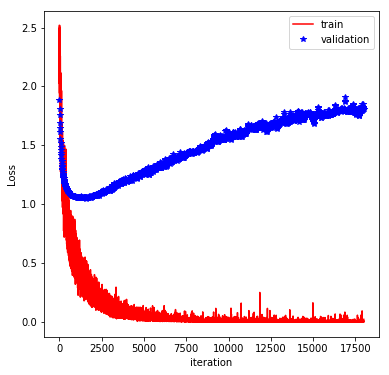

In [13]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

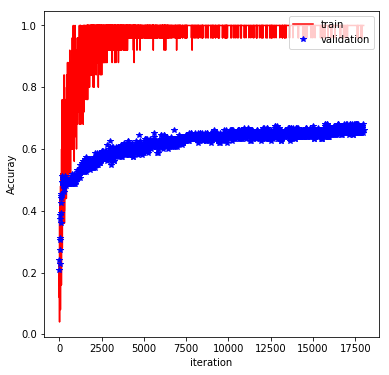

In [14]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [15]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.696667
